# Исследование доходности тарифов компании "Мегалайн"

***Заказчик:*** 

«Мегалайн» — федеральный оператор сотовой связи. 

***Задание:***

Есть два тарифных плана: «Смарт» и «Ультра». Для корректировки рекламного бюджета, необходимо выбрать один их двух тарифов, который приносит больше прибыли. 

***Ход исследования:***

Сделать предварительный анализ анализ тарифов, но присланной выборке клиентов (их 500 человек):  кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

***Описание тарифов:***
- Тариф «Смарт»

  Ежемесячная плата: 550 рублей

  Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
  
  Стоимость услуг сверх тарифного пакета:
  
  минута разговора: 3 рубля
  
  сообщение: 3 рубля
  
  1 Гб интернет-трафика: 200 рублей
  

- Тариф «Ультра»
  
  Ежемесячная плата: 1950 рублей
  
  Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
  
  Стоимость услуг сверх тарифного пакета:
  
  минута разговора: 1 рубль
  
  сообщение: 1 рубль
  
  1 Гб интернет-трафика: 150 рублей

## Анализ и подготовка данных

In [1]:
# импортируем нужные библиотеки
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats as st
import warnings

Откроем и прочитаем данные:

In [2]:
# читаем данные в отдельные переменные
try:
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')
except:
    calls = pd.read_csv('/Users/refresh/Downloads/calls.csv')
    internet = pd.read_csv('/Users/refresh/Downloads/internet.csv')
    messages = pd.read_csv('/Users/refresh/Downloads/messages.csv')
    tariffs = pd.read_csv('/Users/refresh/Downloads/tariffs.csv')
    users = pd.read_csv('/Users/refresh/Downloads/users.csv')

Рассмотрим отдельньно каждую таблицу:


### Таблица tariffs (информация о тарифах):

In [3]:
# информация
tariffs.info()
tariffs.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Столбцы:
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Таблица с тарифами содержит информацию о двух тарифах. Данные выглядят нормально. В этой таблице содержатся константы для нашего исследования, запомним их в переменные:

In [4]:
# константы
# smart
s_payment = int(tariffs.loc[tariffs['tariff_name'] =='smart']['rub_monthly_fee'])
s_minutes = int(tariffs.loc[tariffs['tariff_name']=='smart']['minutes_included'])
s_messages = int(tariffs.loc[tariffs['tariff_name']=='smart']['messages_included'])
s_internet = int(tariffs.loc[tariffs['tariff_name']=='smart']['mb_per_month_included'])
s_minutes_plus = int(tariffs.loc[tariffs['tariff_name']=='smart']['rub_per_minute'])
s_messages_plus = int(tariffs.loc[tariffs['tariff_name']=='smart']['rub_per_message'])
s_internet_plus = int(tariffs.loc[tariffs['tariff_name']=='smart']['rub_per_gb'])

# ultra
u_payment = int(tariffs.loc[tariffs['tariff_name']=='ultra']['rub_monthly_fee'])
u_minutes = int(tariffs.loc[tariffs['tariff_name']=='ultra']['minutes_included'])
u_messages = int(tariffs.loc[tariffs['tariff_name']=='ultra']['messages_included'])
u_internet = int(tariffs.loc[tariffs['tariff_name']=='ultra']['mb_per_month_included'])
u_minutes_plus = int(tariffs.loc[tariffs['tariff_name']=='ultra']['rub_per_minute'])
u_messages_plus = int(tariffs.loc[tariffs['tariff_name']=='ultra']['rub_per_message'])
u_internet_plus = int(tariffs.loc[tariffs['tariff_name']=='ultra']['rub_per_gb'])

### Таблица calls (информация о звонках):

In [5]:
# смотрим информацию
calls.info()
calls.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000


Столбцы:
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

В таблице нет пропущенных значний.

Тип данных в длительности звонка не удобный, поменяем на дату:

In [6]:
# используем функцию to_datetime для преобразования в формат даты
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['call_date'].head(3)

0   2018-07-25
1   2018-08-17
2   2018-06-11
Name: call_date, dtype: datetime64[ns]

«Мегалайн» всегда округляет секунды до минут в большую сторону. Округлим и поменяем тип на целочисленный:

In [7]:
# округляем в большую сторону np.ceil, делаем целочисленный тип и проверяем
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = calls['duration'].astype(int)
calls.head(3)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000


### Таблица internet (информация об интернет-сессиях):

In [8]:
# смотрим информацию
internet.info()
internet.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000


Столбцы:
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

В таблице нет пропусков

Не понятно назначние столбца Unnamed: 0.

In [9]:
# смотрим уникальные значения
internet['Unnamed: 0'].unique()

array([     0,      1,      2, ..., 149393, 149394, 149395])

Скорее всего это столбец с индексами, он нам не нужен.

In [10]:
# удаляем функцией drop
internet = internet.drop(['Unnamed: 0'], axis=1)
internet.head(3)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000


Поменяем тип данных в дате интернет-сессии:

In [11]:
# преобразуем тип в дату
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['session_date'].head(3)

0   2018-11-25
1   2018-09-07
2   2018-06-25
Name: session_date, dtype: datetime64[ns]

Считаем количество трафика за месяц и округляем в большую сторону.

In [12]:
# добавляем столбец с месяцами
internet['month'] = internet['session_date'].dt.month_name()
# группируем по клиенту, месяцу и сумме трафика
internet_gb = internet.pivot_table(index=['user_id', 'month'] , values='mb_used', aggfunc='sum')
# добавляем столбец с округлёнными гигабайтами
internet_gb['gb_used'] = np.ceil(internet_gb['mb_used'] / 1024)
internet_gb.head()

mb_used  gb_used
user_id month                      
1000    August    14055.93     14.0
        December   9817.61     10.0
        July      14003.64     14.0
        June      23233.77     23.0
        May        2253.49      3.0

### Таблица messages (информация о сообщениях):

In [13]:
# информация
messages.info()
messages.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000


Столбцы:
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

В таблице пропусков нет. Данные выглядят корректно. В столбце с датой поменяем тип данных.

In [14]:
# приводим информацию к типу дата
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

Добавим месяц в таблицу.

In [15]:
# добавляем месяц в сообщения
messages['month'] = messages['message_date'].dt.month_name()
messages.head(3)

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,June
1,1000_1,2018-10-08,1000,October
2,1000_2,2018-08-04,1000,August


### Таблица users

In [16]:
# инфориация
users.info()
users.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart


Столбцы:
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

В таблице есть пропуски, но они там не случайно. Дату надо привести к соответсвующщему типу.

In [17]:
# приводим к формату дата
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

In [18]:
# проверка на то, что в данных присутсвуют только два данных в исследовании тарифа 
print(f"разновидности тарифов {users['tariff'].unique()}")

разновидности тарифов ['ultra' 'smart']


Проверим данные о возрастах:

In [19]:
# описание
users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

В норме.

### Вывод:
В данных нет пропусков, некоторые типы данных мы скорректировали и привели данные о трафике и времени звонков в соответсвие с учетом в компании. Аномальных значений и выбросов не наблюдается.

 ## Дубликаты

In [20]:
# функцией duplicated() проверим сумму дубликатов в таблиах
# таблицу tariffs проверять нет смысла, там 2 строки
print(f"дубликатов calls: {calls.duplicated().sum()}")
print(f"дубликатов internet: {internet.duplicated().sum()}")
print(f"дубликатов messages: {messages.duplicated().sum()}")
print(f"дубликатов users: {users.duplicated().sum()}")

дубликатов calls: 0
дубликатов internet: 0
дубликатов messages: 0
дубликатов users: 0


Дубликатов нет.

## Расчёты по каждому пользователю

### Количество сделанных звонков и израсходованных минут разговора по месяцам

Добавим месяца в таблицу calls:

In [21]:
# в новый столбец запишем месяца фунцией dt.month
calls['month'] = calls['call_date'].dt.month_name()
# напишем функцию, которая возвращает русскиязычный месяц
def rus_month(month):
    if month == 1:
        return 'Январь'
    elif month == 2:
        return 'Февраль'
    elif month == 3:
        return 'Март'
    elif month == 4:
        return 'Апрель'
    elif month == 5:
        return 'Май'
    elif month == 6:
        return 'Июнь'
    elif month == 7:
        return 'Июль'
    elif month == 8:
        return 'Август'
    elif month == 9:
        return 'Сентябрь'
    elif month == 10:
        return 'Октябрь'
    elif month == 11:
        return 'Ноябрь'
    else:
        return 'Декабрь'
# применим к столбцу с месяцами
#calls['month'] = calls['month'].apply(rus_month)
calls.head(3)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,July
1,1000_1,2018-08-17,0,1000,August
2,1000_2,2018-06-11,3,1000,June


Посчитаем количество месяцев, которые клиенты подключены к "Мегалайн".

In [22]:
# проверяем все ли подключились в 2018 году
users['year'] = users['reg_date'].dt.year
print('все клинты подключились в ', users['year'].unique())

все клинты подключились в  [2018]


In [23]:
# считаем количество месяцев тех, кто прекратил пользоваться
users['months_in'] = users['churn_date'].dt.month - users['reg_date'].dt.month
# считаем количество месяцев тех, кто подключён 
users['months_in'] = users['months_in'].fillna(12 - users['reg_date'].dt.month)
#  делаем тип данных целочисленный
users['months_in'] = users['months_in'].astype('Int64', errors='ignore')
# рассчёт обоненской платы за весь период пользования
users.loc[users['tariff'] == 'smart', 'months_in'] = users['months_in'] * int(s_payment)
users.loc[users['tariff'] == 'ultra', 'months_in'] = users['months_in'] * int(u_payment)
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,year,months_in
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018,13650
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,2018,550
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,2018,3300
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,2018,7800
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,2018,13650


Посчитаем сколько минут, сообщений и трафика использовали клиенты:

In [24]:
# группируем по клиенту и месяцу
calls_used = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum')
messages_used = messages.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count')
internet_used = internet_gb.pivot_table(index=['user_id', 'month'], values='gb_used')
display(calls_used.head(3))
display(messages_used.head(3))
internet_used.head(3)

duration
user_id month             
1000    August         408
        December       333
        July           340

message_date
user_id month                 
1000    August              81
        December            70
        July                75

gb_used
user_id month            
1000    August       14.0
        December     10.0
        July         14.0

Объединяем:

In [25]:
# соединяем тадлицы
min_mes_int = calls_used.merge(messages_used, on=['user_id', 'month'], how='outer').merge(internet_used, on=['user_id', 'month'], how='outer')
min_mes_int.head(3)

duration  message_date  gb_used
user_id month                                    
1000    August       408.0          81.0     14.0
        December     333.0          70.0     10.0
        July         340.0          75.0     14.0

Получилась сводная таблица по клиентам за каждый месяц. Теперь занесём в нее тариф и расчитаем переплату по каждому клиенту.

In [26]:
# создаем временную таблицу из номера клиента и тарифа
temp = users[['user_id', 'tariff']]
# соединяем с общими расчётами
user_tarif = temp.merge(min_mes_int, on='user_id', how='left')
# после соединения могут образоваться пустые значения, т к не все используют услуги каждый месяц
# раз в месяце услуг нет, то заполним нулями
user_tarif['message_date'] = user_tarif['message_date'].fillna(0)
user_tarif['gb_used'] = user_tarif['gb_used'].fillna(0)
user_tarif.head()

,user_id,tariff,duration,message_date,gb_used
0,1000,ultra,408.0,81.0,14.0
1,1000,ultra,333.0,70.0,10.0
2,1000,ultra,340.0,75.0,14.0
3,1000,ultra,172.0,60.0,23.0
4,1000,ultra,159.0,22.0,3.0


Построим графики для оценки количества используемых опций.

Синий цвет - Smart

Оранжевый цвет - Ultra

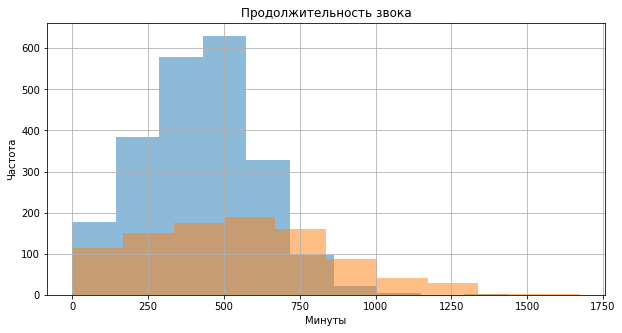

In [27]:
plt.subplots(figsize=(10, 5))
plt.hist(user_tarif.loc[user_tarif['tariff'] == "smart",'duration'], bins=10, alpha=0.5)
plt.hist(user_tarif.loc[user_tarif['tariff'] == "ultra",'duration'], bins=10, alpha=0.5)
plt.grid(True)
plt.xlabel("Минуты")
plt.ylabel("Частота")
plt.title("Продолжительность звока");
plt.show();

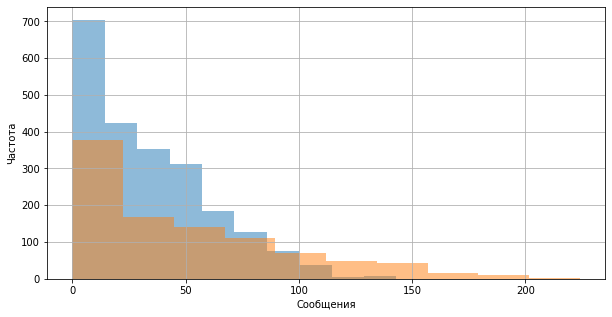

In [28]:
plt.subplots(figsize=(10, 5))
plt.hist(user_tarif.loc[user_tarif['tariff'] == "smart",'message_date'], bins=10, alpha=0.5)
plt.hist(user_tarif.loc[user_tarif['tariff'] == "ultra",'message_date'], bins=10, alpha=0.5)
plt.grid(True)
plt.xlabel("Сообщения")
plt.ylabel("Частота")
plt.show();

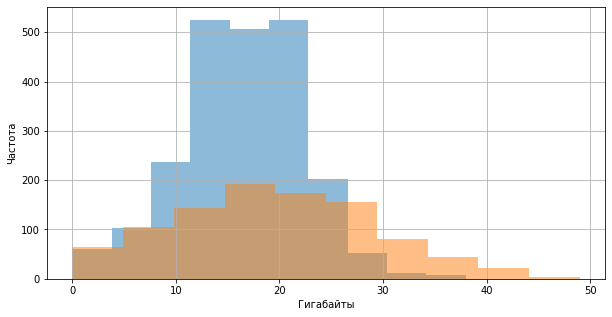

In [29]:
plt.subplots(figsize=(10, 5))
plt.hist(user_tarif.loc[user_tarif['tariff'] == "smart",'gb_used'], bins=10, alpha=0.5)
plt.hist(user_tarif.loc[user_tarif['tariff'] == "ultra",'gb_used'], bins=10, alpha=0.5)
plt.grid(True)
plt.xlabel("Гигабайты")
plt.ylabel("Частота")
plt.show();

**Вывод**

На тарифе Smart определённо больше пользователей, но на тарифе Ultra пользователи больше используют минут, сообщений и интернета. В целом это логично, более дороргой тариф покупают для более интенсивного использования возможномтей.

Напишем функцию, которая посчитает услуги, соответсвенно тарифу:

In [30]:
# функция принимает строку, считае переплату по каждой категории и, если она есть есть, возвращает ее, иначе возвращает ноль
def amount(row):
    call = row['duration']
    mes = row['message_date']
    inte = row['gb_used']
    tariff = row['tariff']
    if tariff == 'smart':
        call = call - s_minutes
        if call < 0:
            call = 0
        else:
            call *= s_minutes_plus
        mes = mes - s_messages
        if mes < 0:
            mes = 0
        else:
            mes *= s_messages_plus
        inte = inte - s_internet/1024
        if inte < 0:
            inte = 0
        else:
            inte *= s_internet_plus
    if tariff == 'ultra':
        call = call - u_minutes
        if call < 0:
            call = 0
        else:
            call *= u_minutes_plus
        mes = mes - u_messages
        if mes < 0:
            mes = 0
        else:
            mes *= u_messages_plus
        inte = inte - u_internet/1024
        if inte < 0:
            inte = 0
        else:
            inte *= u_internet_plus
    return call+mes+inte 
# применяем построчно        
user_tarif['total'] = user_tarif.apply(amount, axis = 1)
user_tarif

,user_id,tariff,duration,message_date,gb_used,total
0,1000,ultra,408.0,81.0,14.0,0.0
1,1000,ultra,333.0,70.0,10.0,0.0
2,1000,ultra,340.0,75.0,14.0,0.0
3,1000,ultra,172.0,60.0,23.0,0.0
4,1000,ultra,159.0,22.0,3.0,0.0
...,...,...,...,...,...,...
3211,1498,smart,471.0,44.0,22.0,1400.0
3212,1499,smart,492.0,66.0,13.0,48.0
3213,1499,smart,612.0,59.0,18.0,963.0
3214,1499,smart,449.0,48.0,18.0,600.0


Посмотрим на графики по допуслугам:

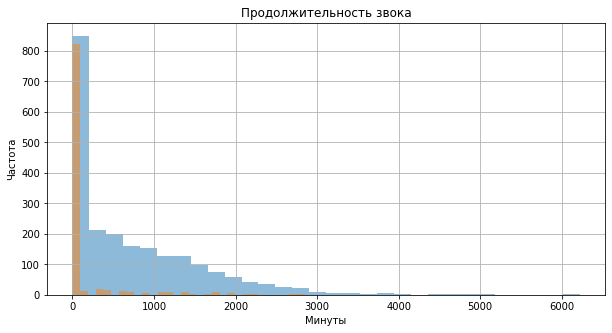

In [34]:
plt.subplots(figsize=(10, 5))
plt.hist(user_tarif.loc[user_tarif['tariff'] == "smart",'total'], bins=30, alpha=0.5)
plt.hist(user_tarif.loc[user_tarif['tariff'] == "ultra",'total'], bins=30, alpha=0.5)
plt.grid(True)
plt.xlabel("Минуты")
plt.ylabel("Частота")
plt.title("Продолжительность звока");
plt.show();

На графике есть только клиенты Smart, проверим значения по другому тарифу:

In [35]:
user_tarif.loc[user_tarif['tariff'] == "ultra",'total'].value_counts()

0.0       823
300.0      19
450.0      17
600.0      13
150.0      11
1050.0     10
1200.0      9
750.0       9
1800.0      9
1350.0      8
900.0       7
1950.0      6
1500.0      4
1650.0      2
2850.0      1
2250.0      1
2100.0      1
2700.0      1
Name: total, dtype: int64

***Вывод по допуслугам***

Клиенты тарифа Ultra укладываются в свои тарифные опции, допуслугами ползуются только пользоваьтели Smart!

Группируем переплату по клиентам:

In [36]:
user_tarif_end = user_tarif.groupby('user_id')['total'].sum()
print('количество клиентов = ', user_tarif_end.shape[0])
print('количество пропусков = ',user_tarif_end.isna().sum())
user_tarif_end.head()

количество клиентов =  500
количество пропусков =  0


user_id
1000       0.0
1001     600.0
1002    3400.0
1003       0.0
1004       0.0
Name: total, dtype: float64

Соединяем с переплату с клиентами и считаем кончную доходность по клиентам:

In [37]:
users_end = users.merge(user_tarif_end, on='user_id', how='inner')
# считаем доходность по клиентам
users_end['profitability'] = users_end['months_in'] + users_end['total']
users_end['profitability'] = users_end['profitability'].astype('Int64', errors='ignore')
users_end.head(3)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,year,months_in,total,profitability
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018,13650,0.0,13650
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,2018,550,600.0,1150
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,2018,3300,3400.0,6700


График и описание доходности:

count      351.000000
mean      7636.612536
std       5417.390636
min          0.000000
25%       3629.500000
50%       6700.000000
75%      10649.000000
max      27801.000000
Name: profitability, dtype: float64


count      149.000000
mean     11726.174497
std       6923.287631
min          0.000000
25%       5850.000000
50%      11700.000000
75%      17550.000000
max      30450.000000
Name: profitability, dtype: float64

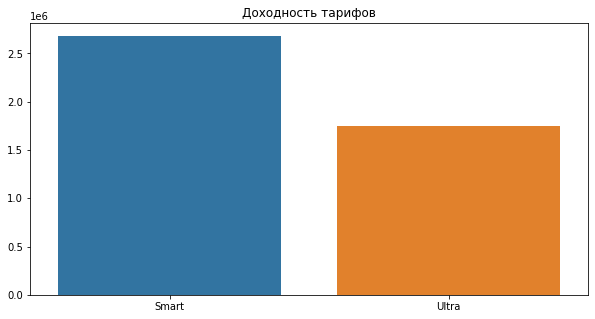

In [38]:
plt.subplots(figsize=(10, 5))
sb.barplot(x=['Smart', 'Ultra'], y=[users_end.loc[users_end['tariff'] == 'smart', 'profitability'].sum(), users_end.loc[users_end['tariff'] == 'ultra', 'profitability'].sum()])
plt.title("Доходность тарифов");
print(users_end.loc[users_end['tariff'] == 'smart', 'profitability'].describe())
users_end.loc[users_end['tariff'] == 'ultra', 'profitability'].describe()

## Вывод по тарифам

Определённо количество клиентов на тарифе смарт больше, они используют дополнительные опции - и приносят больше прибыли.

## Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

Посмотрим средние данные по минутам, которые трятят клиенты, по каждому тарифу.

Smart
среднее  419.06
диспресия  35828.07
сигма  189.28
Ultra
среднее  545.45
диспресия  94104.36
сигма  306.76


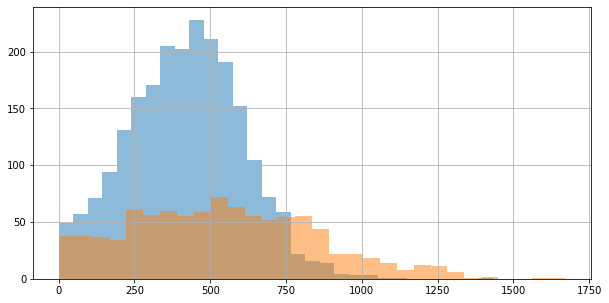

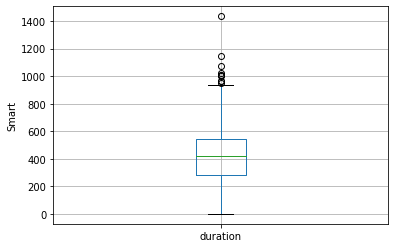

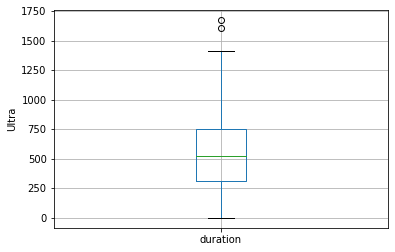

In [40]:
# среднее количество минут каждого пользователя по тарифу
s_calls = calls.merge(temp, on='user_id', how='left')\
.query('tariff == "smart"')\
.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum')\
.reset_index()
u_calls = calls.merge(temp, on='user_id', how='left')\
.query('tariff == "ultra"')\
.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum')\
.reset_index()
s_var_calls = np.var(s_calls['duration'])
u_var_calls = np.var(u_calls['duration'])
print('Smart')
print('среднее ', round(s_calls['duration'].mean(), 2))
print('диспресия ', round(s_var_calls, 2))
print('сигма ', round(np.sqrt(s_var_calls), 2))
print('Ultra')
print('среднее ', round(u_calls['duration'].mean(),2))
print('диспресия ', round(u_var_calls, 2))
print('сигма ', round(np.sqrt(u_var_calls), 2))

# строим гисторграммы
plt.subplots(figsize=(10, 5))
plt.hist(s_calls['duration'], bins=30, alpha=0.5)
plt.hist(u_calls['duration'], bins=30, alpha=0.5)
plt.grid(True)
plt.show();
s_calls.boxplot(column='duration')
plt.ylabel('Smart')
plt.show();
u_calls.boxplot(column='duration')
plt.ylabel('Ultra');

### Вывод минуты

Распределение среднего времени звонков в месяц у тарифа Smart находиться около 419 мин, с возможным увеличением до 900 минут. У тарифа Ultra среднее около 545 мин, с увеличением до 1300. Поэтому пользователи Smart используют дополнительные минуты.

По аналогии посчитаем сообщения и интернет трафик.

In [41]:
messages

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,June
1,1000_1,2018-10-08,1000,October
2,1000_2,2018-08-04,1000,August
3,1000_3,2018-06-16,1000,June
4,1000_4,2018-12-05,1000,December
...,...,...,...,...
123031,1499_179,2018-12-12,1499,December
123032,1499_180,2018-09-28,1499,September
123033,1499_181,2018-09-27,1499,September
123034,1499_182,2018-11-15,1499,November


Smart
среднее  38.72
диспресия  717.22
сигма  26.78
Ultra
среднее  61.16
диспресия  2107.01
сигма  45.9


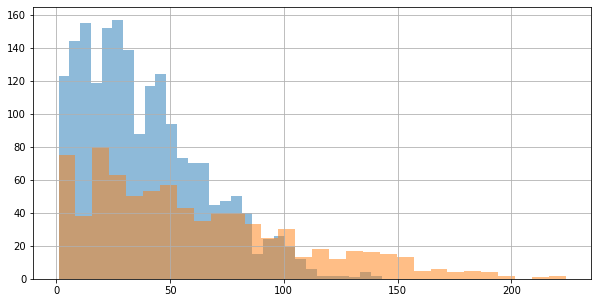

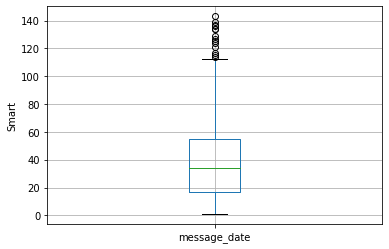

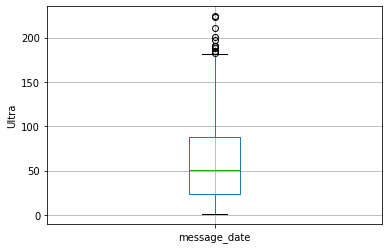

In [42]:
s_messages = messages.merge(temp, on='user_id', how='left')\
.query('tariff == "smart"')\
.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count')\
.reset_index()
u_messages = messages.merge(temp, on='user_id', how='left')\
.query('tariff == "ultra"')\
.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count')\
.reset_index()
s_var_messages = np.var(s_messages['message_date'])
u_var_messages = np.var(u_messages['message_date'])
print('Smart')
print('среднее ', round(s_messages['message_date'].mean(), 2))
print('диспресия ', round(s_var_messages, 2))
print('сигма ', round(np.sqrt(s_var_messages), 2))
print('Ultra')
print('среднее ', round(u_messages['message_date'].mean(),2))
print('диспресия ', round(u_var_messages, 2))
print('сигма ', round(np.sqrt(u_var_messages), 2))

# строим гисторграммы
plt.subplots(figsize=(10, 5))
plt.hist(s_messages['message_date'], bins=30, alpha=0.5)
plt.hist(u_messages['message_date'], bins=30, alpha=0.5)
plt.grid(True)
plt.show();
s_messages.boxplot(column='message_date')
plt.ylabel('Smart')
plt.show();
u_messages.boxplot(column='message_date')
plt.ylabel('Ultra');

### Вывод сообщения

Распределение среднего количества сообщений в месяц у тарифа Smart находиться около 38 мин, с возможным увеличением до 110 шт. У тарифа Ultra среднее около 60, с увеличением до 200. Поэтому пользователи Smart используют дополнительные сообщения.

Tрафик.

Smart
среднее  16.34
диспресия  32.91
сигма  5.74
Ultra
среднее  19.69
диспресия  94.05
сигма  9.7


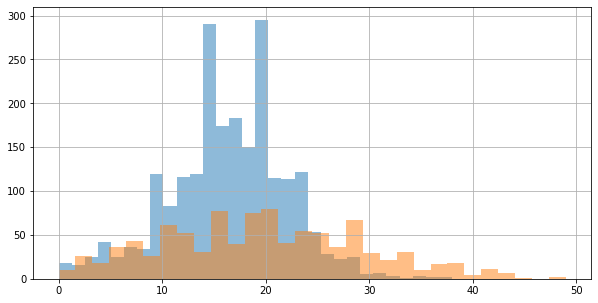

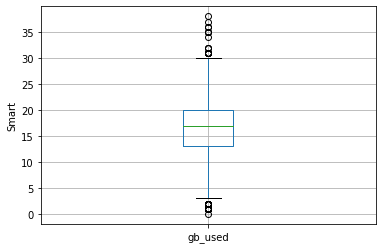

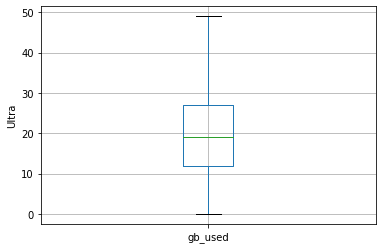

In [43]:
s_internet = internet_gb.merge(temp, on='user_id', how='left')\
.query('tariff == "smart"')\
.reset_index()
u_internet = internet_gb.merge(temp, on='user_id', how='left')\
.query('tariff == "ultra"')\
.reset_index()
s_var_internet = np.var(s_internet['gb_used'])
u_var_internet = np.var(u_internet['gb_used'])
print('Smart')
print('среднее ', round(s_internet['gb_used'].mean(), 2))
print('диспресия ', round(s_var_internet, 2))
print('сигма ', round(np.sqrt(s_var_internet), 2))
print('Ultra')
print('среднее ', round(u_internet['gb_used'].mean(),2))
print('диспресия ', round(u_var_internet, 2))
print('сигма ', round(np.sqrt(u_var_internet), 2))

# строим гисторграммы
plt.subplots(figsize=(10, 5))
plt.hist(s_internet['gb_used'], bins=30, alpha=0.5)
plt.hist(u_internet['gb_used'], bins=30, alpha=0.5)
plt.grid(True)
plt.show();
s_internet.boxplot(column='gb_used')
plt.ylabel('Smart')
plt.show();
u_internet.boxplot(column='gb_used')
plt.ylabel('Ultra');

### Вывод сообщения

Распределение среднего количества трафика в месяц у тарифа Smart находиться около 16 мин, с возможным увеличением до 30 шт. У тарифа Ultra среднее около 19, с увеличением до 48. Поэтому пользователи Smart используют дополнительные гигабайты.

# Проверка гипотез

### Cредняя выручка пользователей тарифов Smart и Ultra различаются

Т к нулевую гипотезу лучше выбирать со знаком равенства:

Нулевая гипотеза: Cредняя выручка пользователей тарифов Smart и Ultra не различаются
Альтернативная гипотеза: Cредняя выручка пользователей тарифов Smart и Ultra различаются

Будем использовать критерий оценки 1%, т к пользователей у нас всего 500, а компания федерального уровня и в реальности клиентов может быть намного больше.


Сделаем две выборки по трифам:

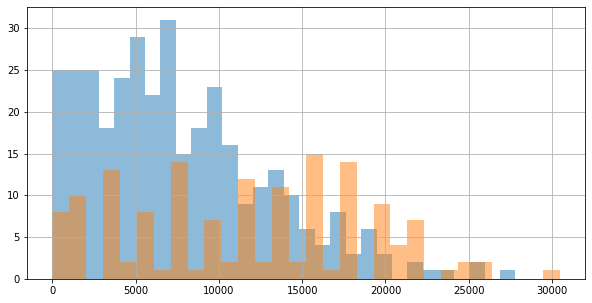

In [44]:
# формируем выборки
sample_1 = users_end.loc[users_end['tariff'] == 'smart', 'profitability']
sample_2 = users_end.loc[users_end['tariff'] == 'ultra', 'profitability']
# строим гисторграммы
plt.subplots(figsize=(10, 5))
plt.hist(sample_1, bins=30, alpha=0.5)
plt.hist(sample_2, bins=30, alpha=0.5)
plt.grid(True)
plt.show();

In [45]:
# уровень критической значимости
alpha = .01
# делаем t-test для двух выборок, исперсии предполагаем разные
t_st, p_val = st.ttest_ind(sample_1, sample_2, equal_var=False)
# выводы и проверка гипотезы
print(f't-критерий составил {round(t_st, 2)}')
print(f'Рассчитанный t-критерий дает достигаемый уровень значимости (p-value) равный {round(p_val,7)}')
if p_val < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не можем отвергнуть нулевую гипотезу')

t-критерий составил -6.42
Рассчитанный t-критерий дает достигаемый уровень значимости (p-value) равный 0.0
Отвергаем нулевую гипотезу


### Cредняя выручка пользователей из Москвы и выручки пользователей из других регионов.

Нулевая гипотеза: Cредняя выручка пользователей тарифов из Москвы и выручки пользователей из других регионов не различаются. 

Альтернативная гипотеза: редняя выручка пользователей тарифов Smart и Ultra из Москвы и выручки пользователей из других регионов  различаются.

Будем использовать критерий оценки 1%

In [46]:
# формируем выборки
sample_3 = users_end.loc[users_end['city'] == 'Москва', 'profitability']
sample_4 = users_end.loc[users_end['city'] != 'Москва', 'profitability']
# делаем t-test для двух выборок, исперсии предполагаем разные
t_st, p_val = st.ttest_ind(sample_3, sample_4, equal_var=False)
# выводы и проверка гипотезы
print(f't-критерий составил {round(t_st, 2)}')
print(f'Рассчитанный t-критерий дает достигаемый уровень значимости (p-value) равный {round(p_val,7)}')
if p_val < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не можем отвергнуть нулевую гипотезу')

t-критерий составил -0.55
Рассчитанный t-критерий дает достигаемый уровень значимости (p-value) равный 0.5819206
Не можем отвергнуть нулевую гипотезу


# Выводы

Мы провели исследование пользователей компании "Мегалайн". В полученных данных не было значимых пропусков. И не пришлось тратить время на заполнение недостающих данных. Некоторые типы данных мы скорректировали и привели данные о трафике и времени звонков в соответсвие с учетом в компании. Аномальных значений и выбросов не наблюдается.

Исследование показало, что пользователи тарифа Смарт и Ультра ведут себя по разному.
Тариф Ульта используют в оновном в рамках тех опций, которые в него входят, а тариф Смарт превышают лимиты. И на выборке, которую мы получили явно видно, что писпользование тарифа Ультра приносят большую выгоду компании и его стоит продвигать в рекламе лучше.
Исследование так же показало, что по всей территории присутсвия компании стоит уделить внимание именно тарифу ***Ульта***.